![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Face Recognition (1:N) using AdaFace

... and some evaluation metrics used in biometrics

In [ ]:
!git clone https://github.com/mk-minchul/AdaFace
!mkdir /content/AdaFace/pretrained
!wget https://www.dropbox.com/scl/fi/5pvwapkas67jy9ypoarx3/adaface_ir50_ms1mv2.ckpt?rlkey=kgnqrjajlj2yt2c17dq8zn33r
!mv adaface_ir50_ms1mv2.ckpt?rlkey=kgnqrjajlj2yt2c17dq8zn33r /content/AdaFace/pretrained/adaface_ir50_ms1mv2.ckpt
!pip install pytorch-lightning

Cloning into 'AdaFace'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 233 (delta 56), reused 50 (delta 50), pack-reused 147
Receiving objects: 100% (233/233), 38.94 MiB | 10.45 MiB/s, done.
Resolving deltas: 100% (88/88), done.
--2023-10-18 15:27:40--  https://www.dropbox.com/scl/fi/5pvwapkas67jy9ypoarx3/adaface_ir50_ms1mv2.ckpt?rlkey=kgnqrjajlj2yt2c17dq8zn33r
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc9f9a68c2cc9e3287ff8315c47.dl.dropboxusercontent.com/cd/0/inline/CF3LgHC6-XmY79zRPmdDxGLaIsPVgMnB1P1sV64h-QJ8ItQATZ9kfNjCca4m8Pd5dzthT_dWWttRCBtyiuSS2RbG8GMAenxkEQuqz4HUrw6h5mcXGjABewNsdDYYyJmcn-U/file# [following]
--2023-10-18 15:27:40--  https://ucc9f9a68c2cc9e3287ff8315c47.dl.dropboxuser

In [ ]:
# AdaFace library - old version
#!git clone https://github.com/mk-minchul/AdaFace
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1eUaSHG4pGlIZK7hBkqjyp2fc2epKoBvI
#!mkdir /content/AdaFace/pretrained
#!mv /content/adaface_ir50_ms1mv2.ckpt /content/AdaFace/pretrained/
#!pip install pytorch-lightning

In [ ]:
# Library for Face Detection
!pip3 install mtcnn
!pip3 install opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.0 MB/s eta 0:00:00


In [ ]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()

In [ ]:
# For genuine/impostor curves
!pip install pyeer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyeer: filename=pyeer-0.5.5-py3-none-any.whl size=604243 sha256=d9aad6959952470b4a2342ec6f3ce582cdfa6b0bfac829c6fc806f0f167d6afc
  Stored in directory: /root/.cache/pip/wheels/b2/35/95/ffbc717934ddf6a969132945aee46473a34f77e915e1592b7b
Successfully built pyeer


# Data

# Libraries

In [ ]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from   PIL import Image
import matplotlib.pyplot as plt
import os, fnmatch
from   google.colab.patches import cv2_imshow
import seaborn as sn
from   collections import namedtuple
from   tqdm.auto import tqdm
from   pyeer.eer_info import get_eer_stats
from   pyeer.plot import plot_eer_stats


# Functions

In [ ]:
%cd /content/AdaFace

/content/AdaFace


In [ ]:
from face_alignment import align
from inference import load_pretrained_model, to_input

model = load_pretrained_model('ir_50')

/content/AdaFace/face_alignment/mtcnn_pytorch/src/align_trans.py:287: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if align_type is 'cv2_affine':
/content/AdaFace/face_alignment/mtcnn_pytorch/src/align_trans.py:290: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif align_type is 'affine':


In [ ]:
# Face detection of an image
def face_coordinates(Ao):
  face_locations = detector.detect_faces(Ao)
  bb = face_locations[0]['box']
  x1 = bb[0]
  x2 = bb[0]+bb[2]
  y1 = bb[1]
  y2 = bb[1]+bb[3]
  print(x1,x2,y1,y2)
  return x1,x2,y1,y2

def facecrop(Ao):
  face_locations = detector.detect_faces(Ao)
  bb = face_locations[0]['box']
  x1 = bb[0]
  x2 = bb[0]+bb[2]
  y1 = bb[1]
  y2 = bb[1]+bb[3]
  A = Ao[y1:y2,x1:x2,:]
  return A

# List of files of a directory
def dirfiles(img_path,img_ext):
  # Example: img_names = dirfiles('/content/Test/','X*.jpg')
  img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
  return img_names

def image2embedding(image_path):
  # Example: x = image2embedding('/content/Test/B000011.jpg')
  A         = cv2.imread(image_path)     # foto de galería
  img       = cv2.resize(A, (112,112))
  coverted  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pil_image = Image.fromarray(coverted)
  bgr_input = to_input(pil_image)
  features, _ = model(bgr_input)
  X = features.detach()
  X = X.numpy()
  return X

# Embedding of a file list
def imagelist2adaface(img_path,img_names):
  # Example: img_names = dirfiles('/content/Test/','X*.jpg')
  #          X = imagelist2adaface('/content/Test/',img_names)
    n = len(img_names)
    embeddings = np.zeros((n,512))
    for i in tqdm(range(n)):
      embeddings[i,:] = image2embedding(img_path+img_names[i])
    return embeddings

# Embedding of an image
def fx_adaface(A):
  img       = cv2.resize(A, (112,112))
  coverted  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pil_image = Image.fromarray(coverted)
  bgr_input = to_input(pil_image)
  features, _ = model(bgr_input)
  X = features.detach()
  X = X.numpy()
  return X


# Labels (ground truth): m face images per subject
def face_labels(Z,m):
  n = Z.shape[0]
  y = np.zeros((n,),int)
  for i in range(n):
    y[i] = i/m
  return y

# Compute genuine and impostor scores
def genuine_impostor_scores(Z,y):
  print('computing genuine/impostor scores...')
  n = Z.shape[0]
  gscores = np.zeros((n*n,))
  iscores = np.zeros((n*n,))
  tg = 0
  ti = 0
  for i in tqdm(range(n)):
    for j in range(n):
      if y[i]==y[j]:
        gscores[tg] = Z[i,j]
        tg = tg+1
      else:
        iscores[ti] = Z[i,j]
        ti = ti+1
  gscores = gscores[0:tg]
  iscores = iscores[0:ti]
  return gscores,iscores

# Basic Example

## Cropping of face 1

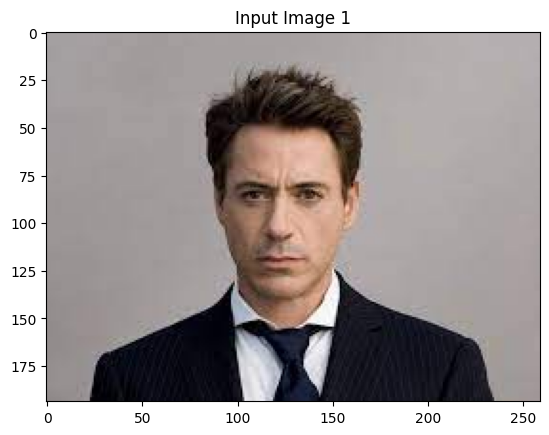

1/1 [==============================] - 0s 350ms/step


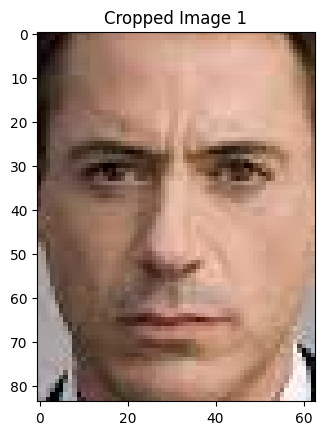

In [ ]:
Ao = cv2.imread('/content/AdaFace/face_alignment/test_images/img1.jpeg')
plt.imshow(cv2.cvtColor(Ao, cv2.COLOR_BGR2RGB))
plt.title('Input Image 1')
plt.show()
A  = facecrop(Ao)
plt.imshow(cv2.cvtColor(A, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image 1')
plt.show()

## Cropping of face 2

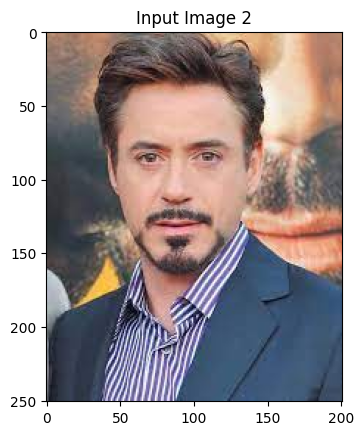

1/1 [==============================] - 0s 190ms/step


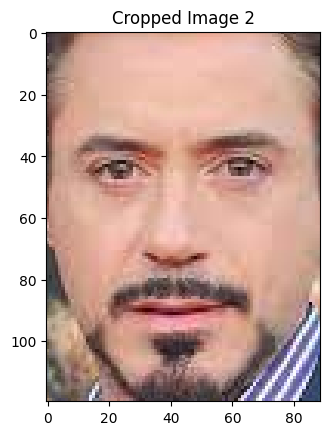

In [ ]:
Bo = cv2.imread('/content/AdaFace/face_alignment/test_images/img2.jpeg')
plt.imshow(cv2.cvtColor(Bo, cv2.COLOR_BGR2RGB))
plt.title('Input Image 2')
plt.show()
B  = facecrop(Bo)
plt.imshow(cv2.cvtColor(B, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image 2')
plt.show()

## Embeddings of both faces

In [ ]:
xA = fx_adaface(A)
xB = fx_adaface(B)

/content/AdaFace/inference.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  tensor = torch.tensor([brg_img.transpose(2,0,1)]).float()


## Matching

In [ ]:
score = np.dot(xA,xB.T)[0]
print(score)

[0.5476515]


# ORL dataset

In [ ]:
!wget https://www.dropbox.com/s/w2y8uo7p0qgx6qr/ORL.zip
!unzip -qq ORL.zip

--2023-10-18 15:33:00--  https://www.dropbox.com/s/w2y8uo7p0qgx6qr/ORL.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w2y8uo7p0qgx6qr/ORL.zip [following]
--2023-10-18 15:33:00--  https://www.dropbox.com/s/raw/w2y8uo7p0qgx6qr/ORL.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe0af33175ce8582307095f02b.dl.dropboxusercontent.com/cd/0/inline/CF0R5cLd55GSXnte9B3rln8LRpqyBWvismRbUJA9AN7Aycoulrg3D8DOca1YvxylRz73cN_nsNwu4YHFgPX5IkqcS5cChtJK2Fn0c03OCTay8R1v4EV_sgo4WkJK_HCBrYU/file# [following]
--2023-10-18 15:33:00--  https://ucbe0af33175ce8582307095f02b.dl.dropboxusercontent.com/cd/0/inline/CF0R5cLd55GSXnte9B3rln8LRpqyBWvismRbUJA9AN7Aycoulrg3D8DOca1YvxylRz73cN_nsNwu4YHFgPX5IkqcS5cChtJK2Fn0c03OCTay8R1v4EV_sgo4WkJK_HCBrYU/fil

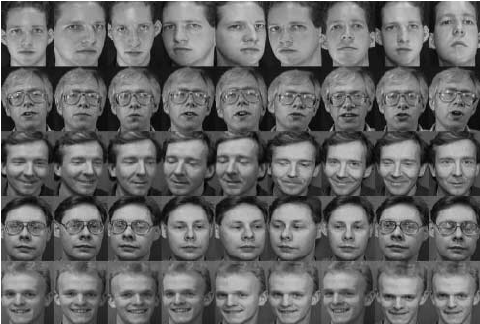

## Individual comparisons

In [ ]:
A18 = image2embedding('ORL/face_18_01.png') # person 18
A19 = image2embedding('ORL/face_19_01.png') # person 19
B18 = image2embedding('ORL/face_18_02.png') # person 18
B19 = image2embedding('ORL/face_19_02.png') # person 19

th = 0.45
print('same person: (score > th) th = '+str(th))
s1 = np.dot(A18,B18.T)
print('comparison: A18 with B18 (same person) -> score: '+str(s1)+' same person? '+str(s1>th))
s2 = np.dot(A19,B19.T)
print('comparison: A19 with B19 (same person) -> score: '+str(s2)+' same person? '+str(s2>th))
s3 = np.dot(A18,B19.T)
print('comparison: A18 with B19 (different person) -> score: '+str(s3)+' same person? '+str(s3>th))
s4 = np.dot(A19,B18.T)
print('comparison: A19 with B18 (different person) -> score: '+str(s4)+' same person? '+str(s4>th))

same person: (score > th) th = 0.45
comparison: A18 with B18 (same person) -> score: [[0.8690969]] same person? [[ True]]
comparison: A19 with B19 (same person) -> score: [[0.52832013]] same person? [[ True]]
comparison: A18 with B19 (different person) -> score: [[0.10222858]] same person? [[False]]
comparison: A19 with B18 (different person) -> score: [[0.06319646]] same person? [[False]]


## Embedding extraction

In [ ]:
fpath = 'ORL/'
img_names = dirfiles(fpath,'face*.png')
X         = imagelist2adaface(fpath,img_names)

  0%|          | 0/400 [00:00<?, ?it/s]

<Axes: >

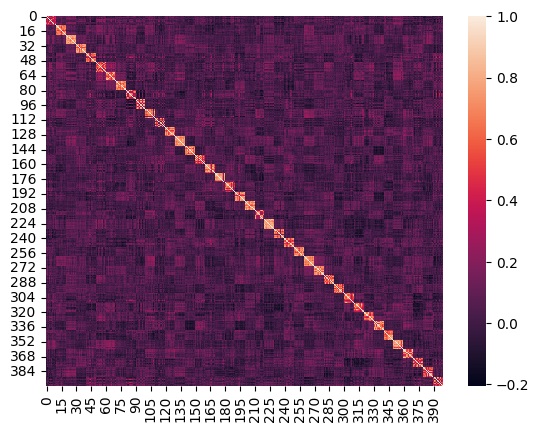

In [ ]:
Z = np.dot(X,X.T)
sn.heatmap(Z, annot=False)

In [ ]:
y = face_labels(Z,10) # labels of GT (10 images per subject)

## Stats

In [ ]:
gscores,iscores = genuine_impostor_scores(Z,y)

computing genuine/impostor scores...


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
# Calculating stats for classifier A

stats = get_eer_stats(gscores, iscores)
plot_eer_stats([stats], ['ORL'])


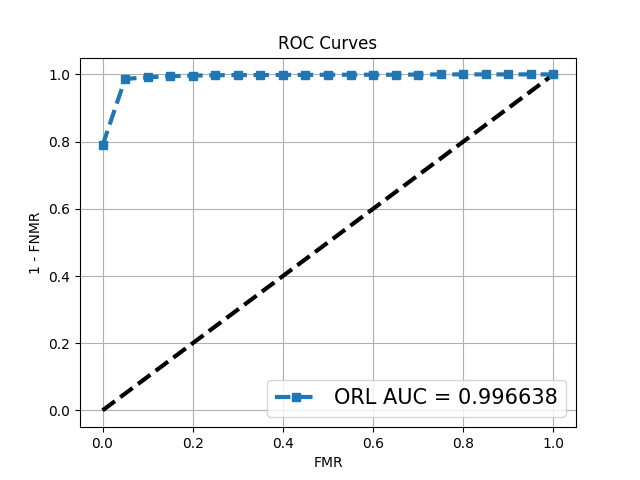

In [ ]:
I = cv2.imread('ROC.png')
cv2_imshow(I)


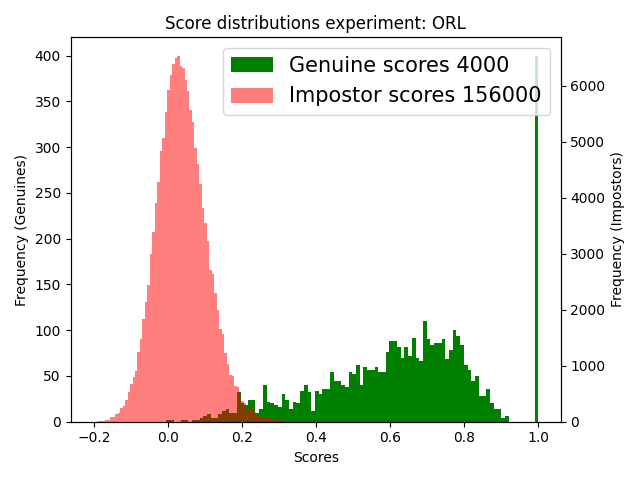

In [ ]:
I = cv2.imread('Distributions (ORL).png')
cv2_imshow(I)


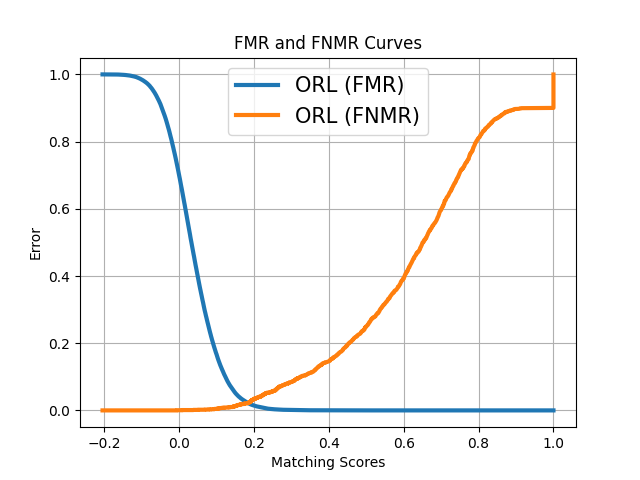

In [ ]:
I = cv2.imread('FMR and FNMR curves (ORL).png');
cv2_imshow(I)

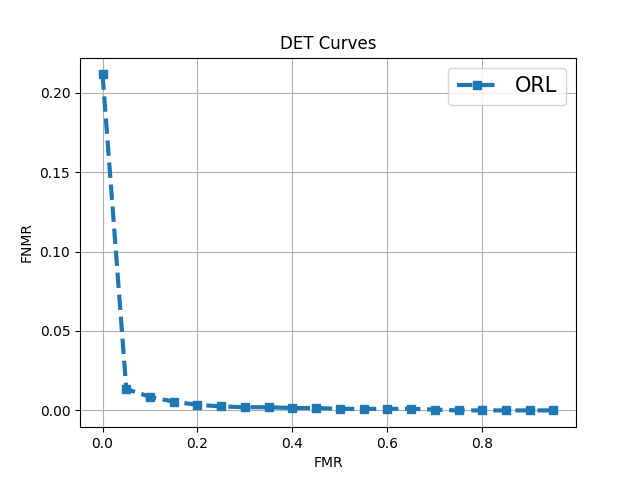

In [ ]:
I = cv2.imread('DET.png');
cv2_imshow(I)

#AR-LQ dataset

3600 images, 100 subjects, 26 images per subject

Heinsohn, D., Villalobos, E., Prieto, L., & Mery, D. (2019). [Face recognition in low-quality images using adaptive sparse representations](https://www.sciencedirect.com/science/article/abs/pii/S0262885619300216). Image and Vision Computing, 85, 46-58.

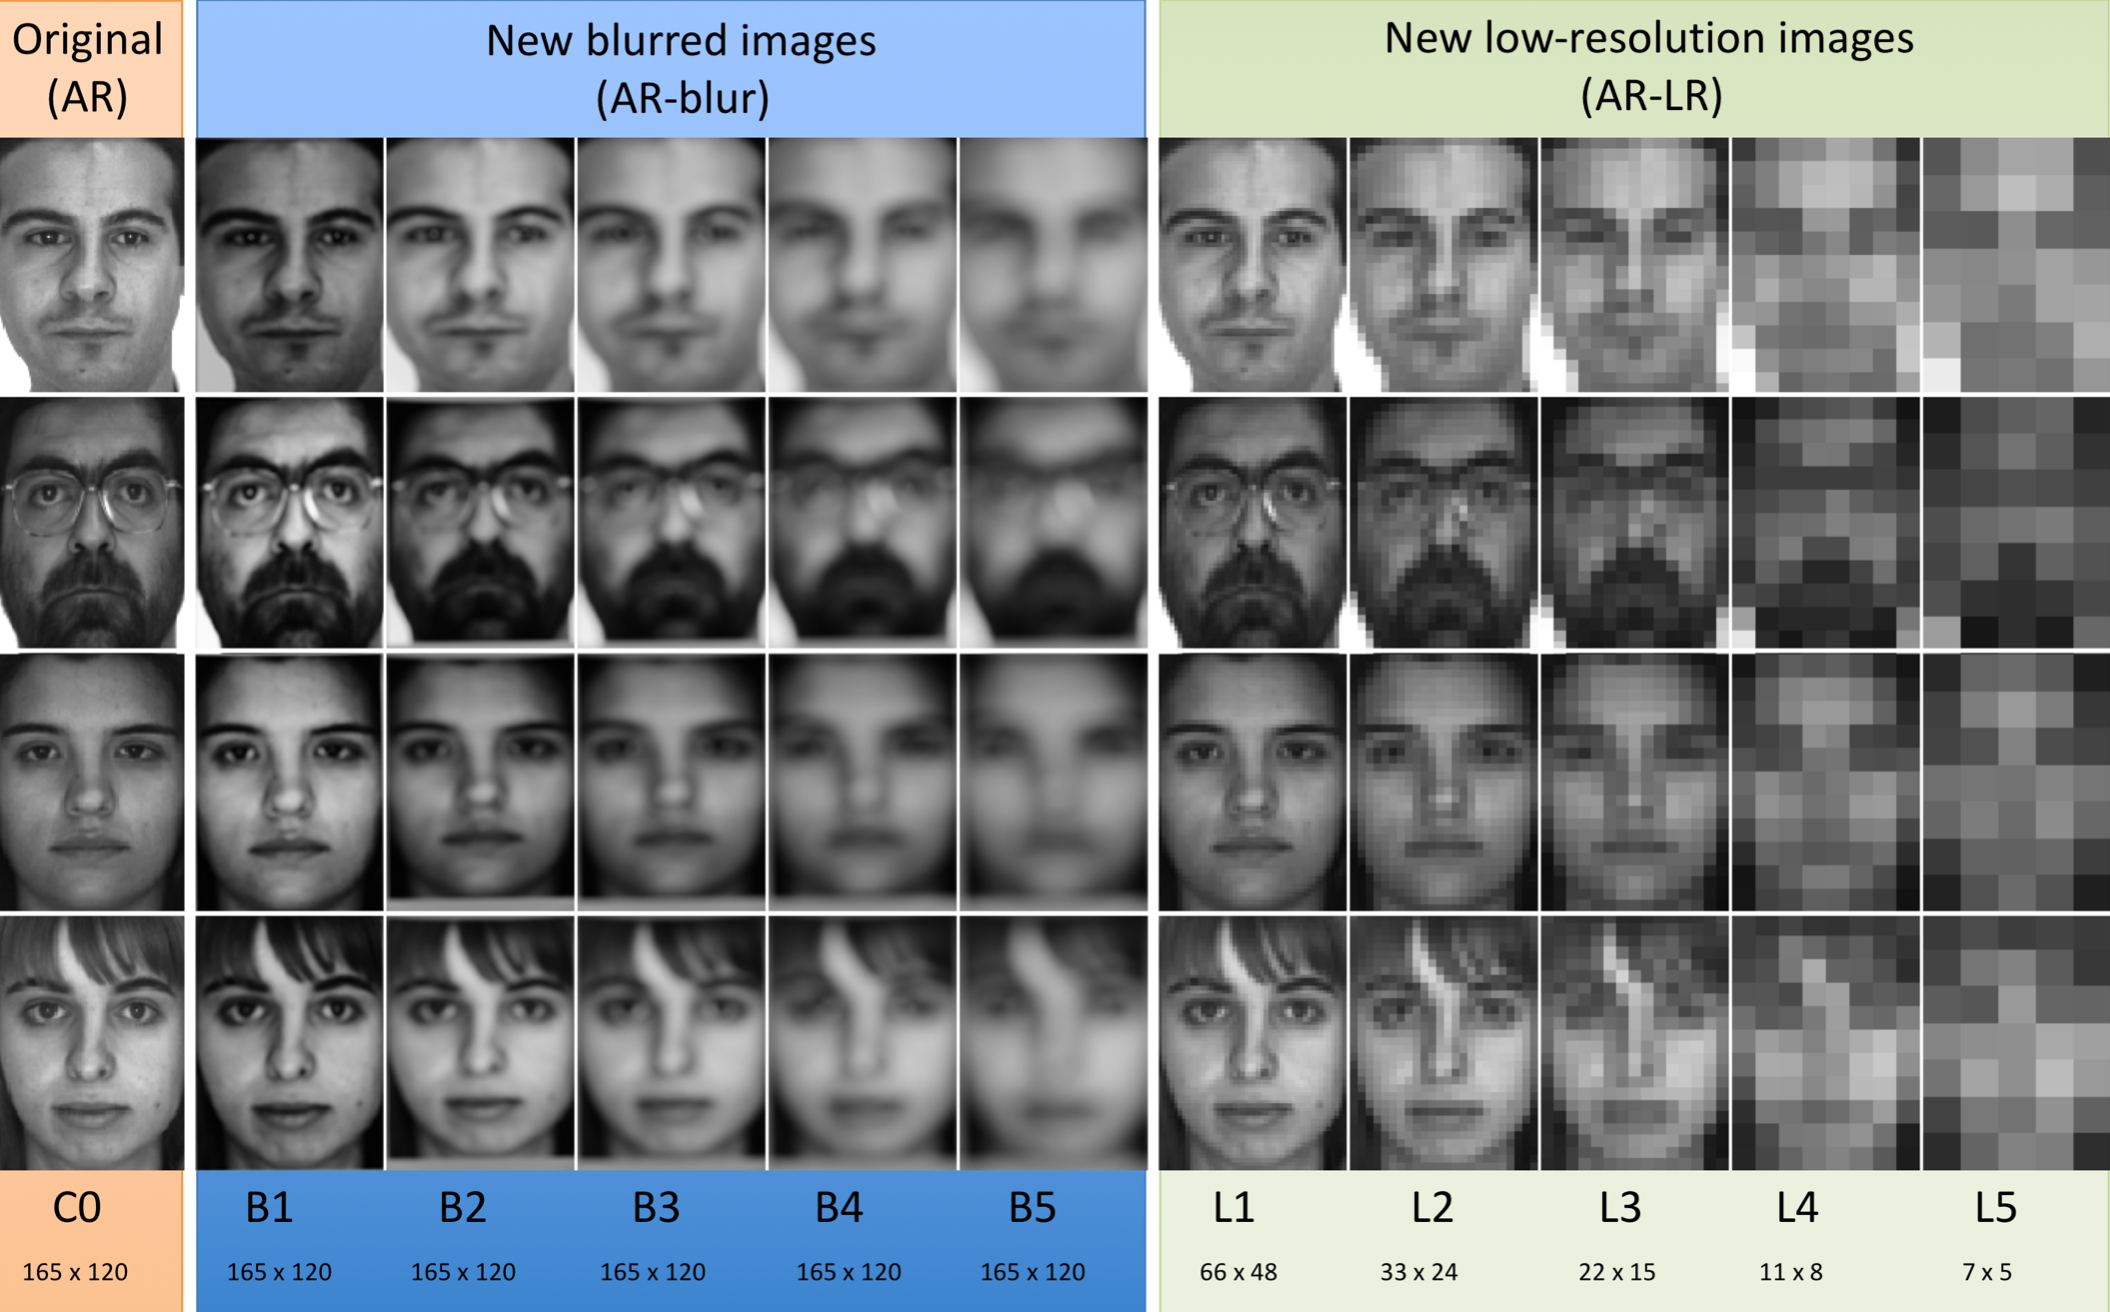

In [ ]:
!wget https://www.dropbox.com/s/zc2obs4a0pn6wp5/faces_ARLQ.zip
!unzip -qq faces_ARLQ.zip

--2023-10-18 15:39:42--  https://www.dropbox.com/s/zc2obs4a0pn6wp5/faces_ARLQ.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zc2obs4a0pn6wp5/faces_ARLQ.zip [following]
--2023-10-18 15:39:42--  https://www.dropbox.com/s/raw/zc2obs4a0pn6wp5/faces_ARLQ.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc19e50897369fc0339d3f6f4fc2.dl.dropboxusercontent.com/cd/0/inline/CF1sQElSg5Qiyk9IywH2PWnOxNn2h6BIEGmExsXisRJkDibxGG942rPySiRq4DIu5-obU4qvs7oVo4-3IBUbKB_w-P2z5sVZlIILFHvy83Xxp5auFf6v92MaoP1_Ru63-Rs/file# [following]
--2023-10-18 15:39:43--  https://uc19e50897369fc0339d3f6f4fc2.dl.dropboxusercontent.com/cd/0/inline/CF1sQElSg5Qiyk9IywH2PWnOxNn2h6BIEGmExsXisRJkDibxGG942rPySiRq4DIu5-obU4qvs7oVo4-3IBUbKB_w-P2z5sVZlIILFHvy83Xxp5auFf

# Embdedding Extraction

WARNING: It takes approx. 5 minutes.

In [ ]:
fpath = 'faces_ARLQ/'
img_names = dirfiles(fpath,'face*.png')
X         = imagelist2adaface(fpath,img_names)

  0%|          | 0/3600 [00:00<?, ?it/s]

# Comparisons

<Axes: >

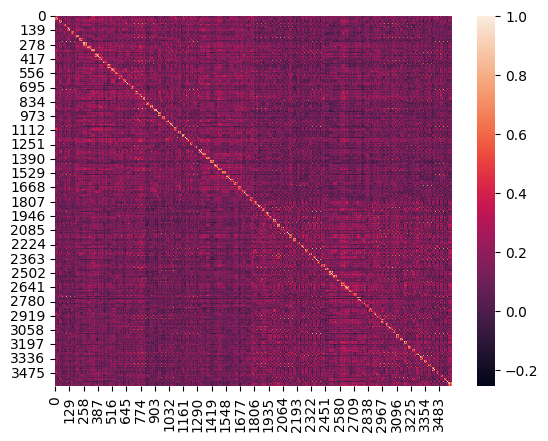

In [ ]:
Z = np.dot(X,X.T)
sn.heatmap(Z, annot=False)

In [ ]:
y = face_labels(Z,36)  # labels of GT (36 images per subject)

In [ ]:
gscores,iscores = genuine_impostor_scores(Z,y)

computing genuine/impostor scores...


  0%|          | 0/3600 [00:00<?, ?it/s]

# Stats

In [ ]:
stats = get_eer_stats(gscores, iscores)
plot_eer_stats([stats], ['ARLQ'])

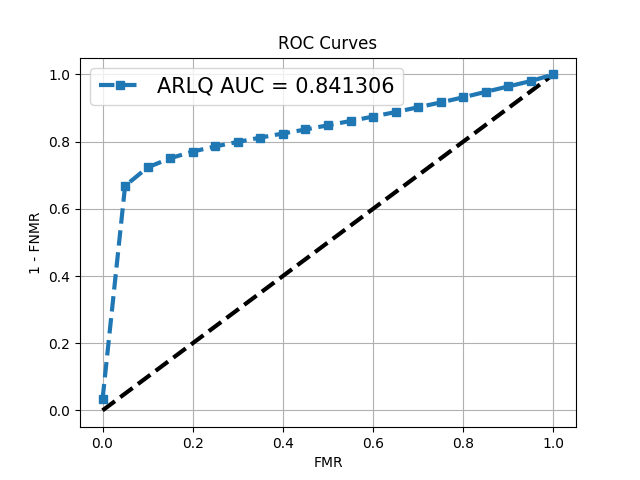

In [ ]:
I = cv2.imread('ROC.png')
cv2_imshow(I)

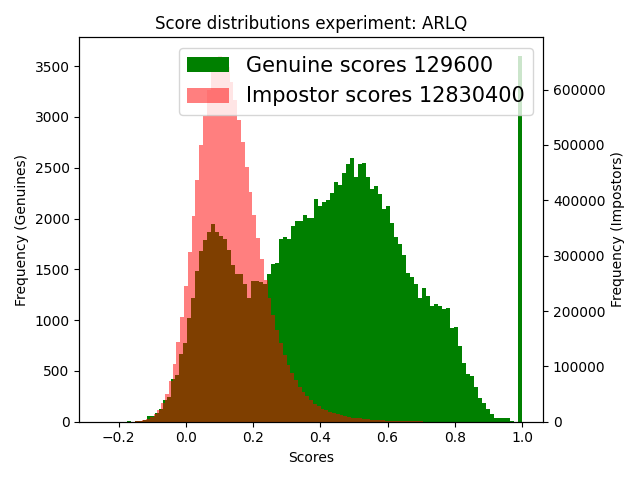

In [ ]:
I = cv2.imread('Distributions (ARLQ).png')
cv2_imshow(I)

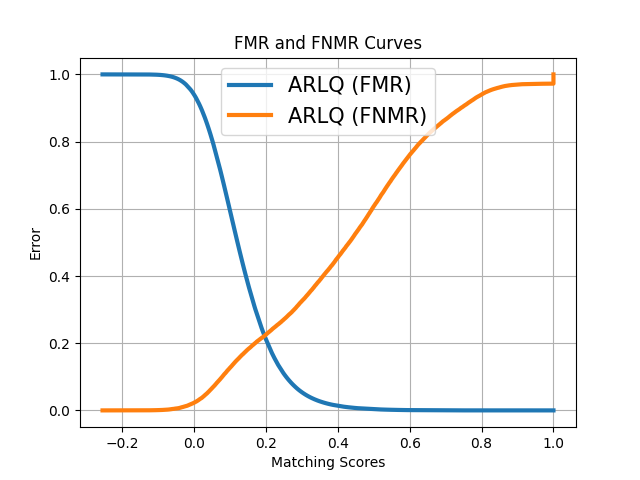

In [ ]:
I = cv2.imread('FMR and FNMR curves (ARLQ).png');
cv2_imshow(I)

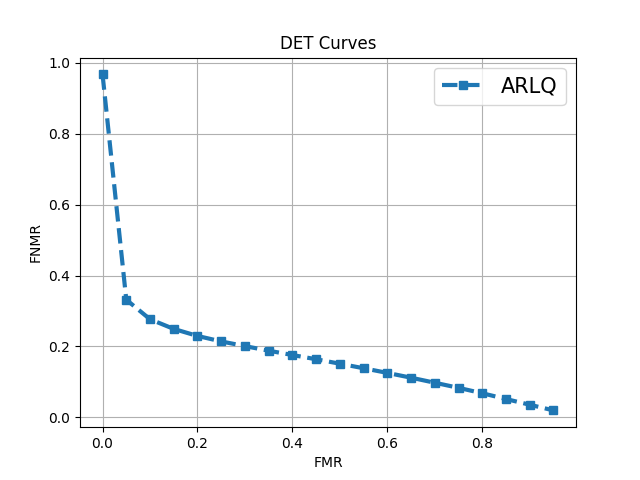

In [ ]:
I = cv2.imread('DET.png');
cv2_imshow(I)